In [33]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as model
import torchvision.utils as vutils
from torch.distributions import Categorical

import random
import numpy as np
import math
from IPython.display import clear_output
from PIL import Image
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt

## Config

In [48]:
# config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_workers = 0
batch_size = 64
lr = 1e-4

## Dataset

In [35]:
# define transform
transfrom = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [36]:
# MNIST dataset
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=transfrom,
    download=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=test_transform,
    download=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)

## VQ-VAE

### Vector Quantizer Class  
Disini kita akan mendefiniskan kelas dan operasi yang ada di bagian tengah dari VQ-VAE.  
K = ukuran code book  
Loss = $\left\| \text{sg}[z_e(x)] - e \right\|_2^2 + \beta \left\| z_e(x) - \text{sg}[e] \right\|_2^2$

In [37]:
class VectorQuantizer(nn.Module):
    def __init__(self, code_book_size, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        '''
        Args :
            code_book_size : jumlah kode (vektor) yayng tersimpan di codebook -- ukuran kamus kuantisasi 
            embedding_dim : dimensi dari codebook -- ukuran vektor di codebook
            commitment_cost : mengontrol seberapa keras encoder dipaksa agar outputnya dekat dengan codebook -- hyperparamater dari commitment loss
        '''
        self.code_book_size = code_book_size
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost

        # inisialisasi codebook
        self.embedding = nn.Embedding(code_book_size, embedding_dim)            # ukuran dari codebook 
        # isi codebook dengan vektor acak dari distribusi uniform
        self.embedding.weight.data.uniform_(-1.0 / code_book_size, 1.0 / code_book_size)

    def forward(self, inputs):
        inputs = inputs.permute(0, 2, 3, 1).contiguous()                        # (batch_size, C, H, W) -> (batch_size, H, W, C)
        input_shape = inputs.shape

        # flatten -> ubah jadi 1D
        flat_input = inputs.view(-1, 1, self.embedding_dim)                     # (batch_size * H * W, 1, C)

        # hitung jarak antara setiap vektor input dengan setiap vektor di codebook
        distances = (flat_input - self.embedding.weight.unsqueeze(0)).pow(2).mean(2)

        # cari indeks dari vektor terdekat di codebook
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)          # (batch_size * H * W, 1)

        # ambil vektor berdasrkan indeks
        quantized = self.embedding(encoding_indices).view(input_shape)          # (batch_size, H, W, C)

        # loss yang mengukur seberapa dekat input dengan vektor di codebook
        loss_1 = F.mse_loss(quantized, inputs.detach())
        loss_2 = self.commitment_cost * F.mse_loss(quantized.detach(), inputs)
        loss = loss_1 + loss_2

        # straight-through estimator ketika training
        # mengalir langsung dari decoder ke encoder tidak mendapat upadate -- input tetap mendapat update gradien
        if self.training:
            quantized = inputs + (quantized - inputs).detach()

        return loss, quantized.permute(0, 3, 1, 2).contiguous(), encoding_indices.reshape(input_shape[0], -1)
    

### Residual Block

Supaya gradien mengalir lebih lama dan representasi belajar lebih dalam tanpa degradasi akibat “vanishing gradient”; skip-connection memungkinkan jaringan hanya mempelajari residual (perubahan kecil) sehingga training stabil dan lebih mudah mencapai akurasi tinggi. -- Kimi

In [38]:
class ResBlock(nn.Module):
    def __init__(self, channels):
        '''
        Args :
            channels : jumlah channel dari input
            num_group : jumlah grup untuk normalisasi -- hyperparameter -- habis membagi batch_size
        '''
        super().__init__()
        
        self.norm = nn.Sequential(
            nn.GroupNorm(8, channels),
            nn.ELU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1),

            nn.GroupNorm(8, channels),
            nn.ELU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1)
        )

    # skip connection
    def forward(self, x):
        return x + self.norm(x)

### Up and Down Block

- Downblock digunakan untuk mengekstrak fitur dan mengurangi dimensi spasial (downsampling)  
- UpBlock digunakan untuk merekontruksi gambar  
    - Pada UpBlock diogunakan UpSample untuk menaikkan ukuran gambar
- Dua block ini akan digunakan di kelas Encoder dan Decoder

In [39]:
class DownBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        '''
        Args : 
            channels_in : jumlah channel dari input
            channels_out : jumlah channel dari output
        '''
        super().__init__()

        # layer normalisasi
        self.norm = nn.GroupNorm(8, channels_in)

        # main path -- jalur utama pemrosesan
        self.main = nn.Sequential(
            nn.Conv2d(channels_in, channels_out, 3, stride=2, padding=1),
            nn.GroupNorm(8, channels_out),
            nn.ELU(inplace=True),
            nn.Conv2d(channels_out, channels_out, 3, stride=1, padding=1)
        )

        # skip
        self.skip = nn.Conv2d(channels_in, channels_out, 3, stride=2, padding=1, bias=False)

    def forward(self, x):
        x = self.norm(x)                        # dinormalisasi
        x = F.elu(x, inplace=True)              # fungsi aktivasi ELU

        return self.main(x) + self.skip(x)      # add elemtnr-wise

In [40]:
class UpBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        '''
        Args :
            channels_in : jumlah channel dari input
            channels_out : jumlah channel dari output
        '''
        super().__init__()

        # layer normalisasi
        self.norm = nn.GroupNorm(8, channels_in)

        # UpSample layer
        self.up = nn.Upsample(scale_factor=2, mode='nearest')

        # main path -- jalur utama pemrosesan
        self.main = nn.Sequential(
            nn.Conv2d(channels_in, channels_in, 3, stride=1, padding=1),
            nn.GroupNorm(8, channels_in),
            nn.ELU(inplace=True),
            nn.Conv2d(channels_in, channels_out, 3, stride=1, padding=1)
        )

        # skip
        self.skip = nn.Conv2d(channels_in, channels_out, 3, stride=1, padding=1, bias=False)

    def forward(self, x):
        x = self.norm(x)
        x = F.elu(x, inplace=True)               # fungsi aktivasi ELU
        x = self.up(x)                           # naikkan ukuran gambar
        return self.main(x) + self.skip(x)       # add element-wise

### Encoder dan Decoder

In [41]:
class Encoder(nn.Module):
    def __init__(self, channels, ch = 32, latent_channels = 32):
        '''
        Args : 
            channels : jumlah channel dari input
            ch : jumlah channel dari output
            latent_channels : jumlah channel dari latent space
        '''
        super(Encoder, self).__init__()

        self.conv_1 = nn.Conv2d(channels, ch, 3, stride=1, padding=1)               # input 

        # Downsampling
        self.conv_block_1 = DownBlock(ch, ch * 2)
        self.conv_block_2 = DownBlock(ch * 2, ch * 4)

        # Residual blocks -- memiliki parameter yang sama untuk mempertahankan bentuk dimensi
        self.res_block_1 = ResBlock(ch * 4)
        self.res_block_2 = ResBlock(ch * 4)
        self.res_block_3 = ResBlock(ch * 4)

        # out layer -> mengubah dimensi ke latent space
        self.conv_out = nn.Conv2d(ch * 4, latent_channels, 3, stride=1, padding=1)

    def forward(self, x):
        x = self.conv_1(x)                        # (batch_size, channels, H, W) -> (batch_size, ch, H, W)
        
        x = self.conv_block_1(x)                  # DownBlock 1
        x = self.conv_block_2(x)                  # DownBlock 2

        x = self.res_block_1(x)                   # ResBlock 1
        x = self.res_block_2(x)                   # ResBlock 2
        x = F.elu(self.res_block_3(x))            # ResBlock 3

        return self.conv_out(x)                    # output ke latent space

In [42]:
class Decoder(nn.Module):
    def __init__(self, channels, ch = 32, latent_channels = 32):
        '''
        Args : 
            channels : jumlah channel dari input
            ch : jumlah channel dari output
            latent_channels : jumlah channel dari latent space
        '''
        super(Decoder, self).__init__()

        self.conv_1 = nn.Conv2d(latent_channels, ch * 4, 3, stride=1, padding=1)    # input dari latent space

        # Upsampling
        self.conv_block_1 = UpBlock(ch * 4, ch * 2)
        self.conv_block_2 = UpBlock(ch * 2, ch)

        # Residual blocks
        self.res_block_1 = ResBlock(ch * 4)
        self.res_block_2 = ResBlock(ch * 4)
        self.res_block_3 = ResBlock(ch * 4)

        # out layer -> rekonstruksi ke gambar asli
        self.conv_out = nn.Conv2d(ch, channels, 3, stride=1, padding=1)               # output ke jumlah channel input

    def forward(self, x):
        x = self.conv_1(x)

        x = self.res_block_1(x)
        x = self.res_block_2(x)
        x = self.res_block_3(x)

        x = self.conv_block_1(x)                  # UpBlock 1
        x = self.conv_block_2(x)                  # UpBlock 2

        return torch.tanh(self.conv_out(x))       # rekonstruksi ke gambar asli dengan fungsi aktivasi tanh

### Visualize data

In [43]:
# Get a test image
dataiter = iter(test_loader)
test_images = next(dataiter)[0]

# View the shape
test_images.shape # (BS, C, H, W)

torch.Size([64, 1, 32, 32])

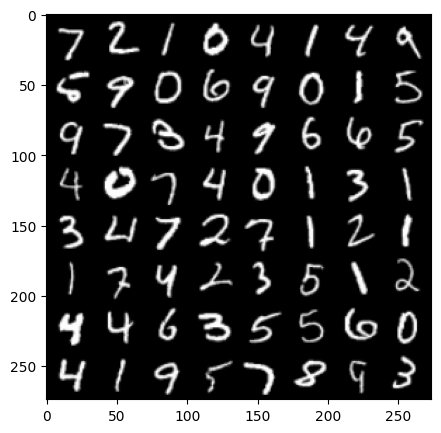

In [44]:
# Visualize the data!!!
plt.figure(figsize = (5,5))
out = vutils.make_grid(test_images, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

### Model

In [45]:
class VQVAE(nn.Module):
    def __init__(self, channel_in, ch = 16, latent_channels = 32, code_book_size = 64, commitment_cost = 0.25):
        super(VQVAE, self).__init__()

        # sisi kiri -- encoder
        self.encoder = Encoder(channels=channel_in, ch=ch, latent_channels=latent_channels)

        # tengah -- Vector Quantizer -- latent space
        self.vq = VectorQuantizer(code_book_size=code_book_size, embedding_dim=latent_channels, commitment_cost=commitment_cost)\
        
        # sisi kanan -- decoder
        self.decoder = Decoder( channels=channel_in, ch=ch, latent_channels=latent_channels)

    def encode(self, x):
        encoded = self.encoder(x)
        vq_loss, quantized, encoding_indices = self.vq(encoded)
        return vq_loss, quantized, encoding_indices
    
    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        vq_loss, quantized, encoding_indices = self.encode(x)
        recon = self.decode(quantized)

        return recon, vq_loss, encoding_indices

### Create network and optimizer

scaler menggunakan `torch.amp.GradScaler` -> membantu training model dengan mixed precision (presisi campuran) pada GPU NVIDIA  

In [46]:
# some config
code_book_size = 32
latent_channels = 10
epochs = 50

In [47]:
# network
vae_net = VQVAE(channel_in=test_images.shape[1],
                latent_channels=latent_channels,
                code_book_size=code_book_size,
                ch=16,
                commitment_cost=0.25).to(device)

In [49]:
# optimizer
optimizer = optim.Adam(vae_net.parameters(), lr=lr)

# add scaler
scaler = torch.amp.GradScaler()  

# lr scheduler
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

### Logger

In [50]:
# loss logger
recon_loss_log = []
qvq_loss_log = []
test_recon_loss_log = []
train_loss_log = []

In [51]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in vae_net.parameters():
    num_model_params += param.flatten().shape[0]

print("-The VQVAE Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, 
                                                                          num_model_params//1e6))

-The VQVAE Model Has 642219 (Approximately 0 Million) Parameters!


## Training 

Loss = $$\mathcal{L} = \underbrace{- \log p(\mathbf{x}|\mathbf{z}_q)}_{\text{Reconstruction Loss}} + \underbrace{\left\| \text{sg}[\mathbf{z}_e(\mathbf{x})] - \mathbf{e} \right\|_2^2}_{\text{Codebook Loss}} + \underbrace{\beta \left\| \mathbf{z}_e(\mathbf{x}) - \text{sg}[\mathbf{e}] \right\|_2^2}_{\text{Commitment Loss}}$$

$$\mathcal{L} = \underbrace{- \log p(\mathbf{x}|\mathbf{z}_q)}_{\text{Reconstruction Loss}} + \underbrace{\left\| \text{sg}[\mathbf{z}_e(\mathbf{x})] - \mathbf{e} \right\|_2^2 + \beta \left\| \mathbf{z}_e(\mathbf{x}) - \text{sg}[\mathbf{e}] \right\|_2^2}_{\text{VQ Loss}}$$

In [ ]:
prog_bar = trange(0, epochs, leave=False, desc="epochs")

for epoch in prog_bar:
    prog_bar.set_postfix_str('Loss : %.4f' % (train_loss_log/len(train_loader)))
    train_loss = 0

    vae_net.train()  # set model to training mode

    # train loop
    for i, data in enumerate(tqdm(train_loader, leave=False, desc="Training")):
        image = image.to(device)

        # aktifkan scaler
        with torch.amp.autocast('cuda'):
            # forward pass
            recon_data, vq_loss, quantized = vae_net(image)

            # hitung loss
            recon_loss = F.mse_loss(recon_data, image)
            loss = recon_loss + vq_loss

        # kembalikan gradien ke nol
        optimizer.zero_grad()
        # backward -- scaler
        scaler.scale(loss).backward()
        # update parameter
        scaler.step(optimizer)
        # update scaler
        scaler.update()